# 1. 深度卷积神经网络（AlexNet）

尽管在引入LeNet之后，CNN在计算机视觉和机器学习社区中广为人知，但它们并没有立即占据主导地位。尽管LeNet在早期的小型数据集上取得了良好的结果，但尚未确定在更大，更现实的数据集上训练CNN的性能和可行性。实际上，在1990年代初期到2012年的分水岭结果之间的大部分时间里，神经网络通常被其他机器学习方法所超越，例如支持向量机。
当初神经网络没有达到现在的水平，原因有很多：
+ 计算能力不足，没有现在显卡如此普及，很难处理多层CNN。
+ 数据集相对较小。
+ 没有初始化启发法
+ 没有随机梯度下降优化
+ 也没有非挤压激活函数
+ 同样没有有效的正则化技术

传统的图像分类主要使用机器学习，但是特征需要从业人员手动生成，其主要流程是：
+ 获取图像数据集；
+ 基于光学，几何学和其他分析工具的一些知识，有时还基于幸运研究生的偶然发现，使用手工制作的功能对数据集进行预处理。
+ 通过标准的特征提取器集（SIFT（尺度不变特征变换），SURF（加速的鲁棒特征））来提供数据调整的管道。
+ 将结果转储到分类器（可能是线性模型或核方法）中，以训练分类器

跟现在的计算机视觉相比，这里有个问题就是，特征不是通过机器学习得来，而是人为生成的。

## 1.1 学习特征表示

对于机器学习来说，整理特征很重要。相当长的时间里，特征都是基于各式各样手工设计的函数从数据中提取的。事实上，不少研究者通过提出新的特征提取函数不断改进图像分类结果。有另外一些人任务，特征也是需要通过学习得来，而不是手动提取，他们相信多层的神经网可以学的数据的多级特征，并能够逐级生成更加抽象的样式。尽管这些人不断尝试，但是由于硬件计算能力有限，以及数据量不够大，导致在很长一段时间内研究停滞不前。

## 1.2 AlexNet 神经网络
直到2012年，使用了8层CNN的AlexNet以惊人的优势赢得了2012年ImageNet大规模视觉识别挑战赛。该网络首次表明，通过学习获得的功能可以超越手动设计的功能，从而打破了计算机视觉的先前范式。

下图为AlexNet和LeNet的体系结构，这里提供的是稍微简化的AlexNet版本，删除了2012年使模型适合两个小型GPU所需的一些设计怪癖。

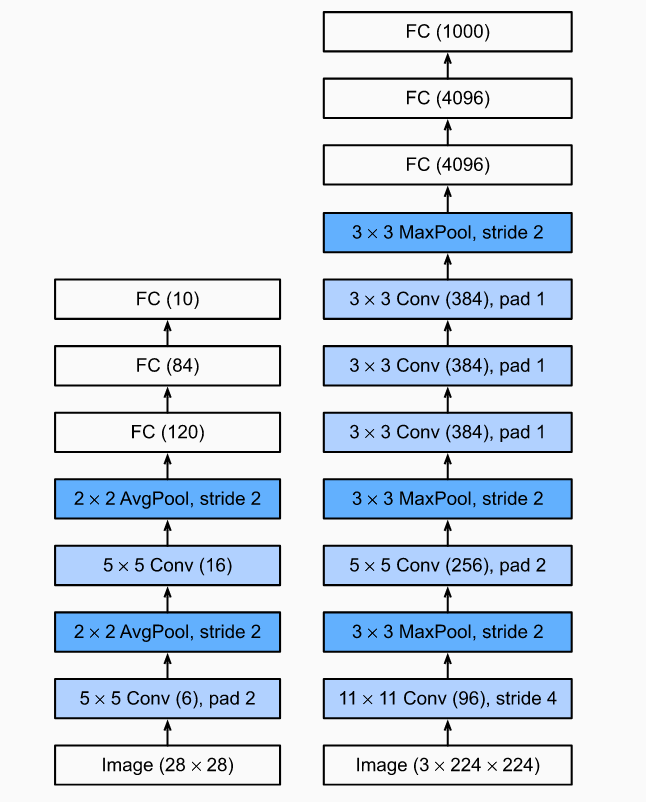

与LeNet相比：
+ AlexNet比相对较小的LeNet5更深入
+ AlexNet使用ReLU而不是S型作为其激活功能

### 1.2.1 结构
在AlexNet的第一层中，卷积窗口形状为  11×11 。由于ImageNet中的大多数图像比MNIST图像高和宽十倍以上，因此ImageNet数据中的对象往往会占据更多像素。因此，需要更大的卷积窗口来捕获对象。第二层中的卷积窗口形状减小为 5×5 ， 其次是  3×3 。此外，在第一，第二和第五卷积层之后，网络会添加窗口形状为  3×3  步幅为2。此外，AlexNet的卷积通道数是LeNet的十倍。
最后一个卷积层之后，有两个具有4096个输出的完全连接的层。这两个巨大的全连接层产生近1 GB的模型参数。

### 1.2.2 激活函数
AlexNet将S形激活功能更改为更简单的ReLU激活功能。S型激活函数的输出非常接近0或1时，这些区域的斜率几乎为0，因此反向传播无法继续更新某些模型参数。相反，ReLU激活函数在正区间中的梯度始终为1。因此，如果未正确初始化模型参数，则S型函数可能会在正区间中获得几乎为0的梯度


## 1.3 容量控制和预处理
+ AlexNet通过dropout控制全连接层的模型复杂性
+ 为了进一步增强数据，AlexNet的训练循环添加了大量图像增强功能，例如翻转，剪切和颜色更改
+ 更大的样本数量有效地减少了过度拟合。

In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx, init, autograd, gluon
from mxnet.gluon import nn
import plotly.graph_objs as go
npx.set_np()

ctx = npx.gpu() if npx.num_gpus() >0 else npx.cpu()

In [2]:
net = nn.Sequential()

net.add (
    # 使用较大的窗口来捕获物体，同时使用步幅4来减小数据的高和宽 ，使用更高的通道数
    # 宽高：（224-11）/4 +1 = 54
    nn.Conv2D(96, kernel_size=11, strides=4, activation='relu'),  
    # 宽高 ：（54-3）/2 +1 = 26
    nn.MaxPool2D(pool_size=3, strides=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    # 5,2 这种组合总是可以保持原来的宽高，3,1，；7,3
    nn.Conv2D(256, kernel_size=5, padding=2, activation='relu'),
    # 宽高： （26-3）/2 +1 =12
    nn.MaxPool2D(pool_size=3, strides=2),
    # 连续三个卷积层，且使用更小的卷积窗口，除了最后的卷积层外，进一步增大了通道数
    # 全两个卷积后不使用池化层
    nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
    nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
    nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
    # 宽高： （12 - 3）/2 +1 = 5
    nn.MaxPool2D(pool_size=3, strides=2),
    # 使用dropout缓解过拟合
    nn.Dense(4096, activation='relu'),
    nn.Dropout(0.5),
    nn.Dense(4096, activation='relu'),
    nn.Dropout(0.5),
    # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10
    nn.Dense(10)
)

+ 查看一下神经网每一层的形状

In [3]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 96, 54, 54)
pool0 output shape:	 (1, 96, 26, 26)
conv1 output shape:	 (1, 256, 26, 26)
pool1 output shape:	 (1, 256, 12, 12)
conv2 output shape:	 (1, 384, 12, 12)
conv3 output shape:	 (1, 384, 12, 12)
conv4 output shape:	 (1, 256, 12, 12)
pool2 output shape:	 (1, 256, 5, 5)
dense0 output shape:	 (1, 4096)
dropout0 output shape:	 (1, 4096)
dense1 output shape:	 (1, 4096)
dropout1 output shape:	 (1, 4096)
dense2 output shape:	 (1, 10)


## 1.4读取数据集
尽管本文对AlexNet进行了ImageNet培训，但是我们在这里使用Fashion-MNIST，因为即使在现代GPU上训练ImageNet模型来收敛也可能需要数小时或数天。将AlexNet直接应用于Fashion-MNIST的问题之一是其图像的分辨率较低（ 28×28 像素）。为了使事情正常进行，我们将其升采样为 224×224 （通常情况不要这样做，这里只是为了模拟AlexNet网络的输入）。

In [4]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

In [5]:
def accuracy(y_hat, y): 
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(d2l.reduce_sum(cmp))

def train_epoch(net, train_iter, loss, updater):
    
    l_sum = acc_rate = total = 0
    
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
        
    for X,y in train_iter:
        X = X.as_in_ctx(ctx)
        y = y.as_in_ctx(ctx)
        with autograd.record():
            pre_y = net(X)
            l = loss(pre_y, y)
        l.backward()
        updater(y.size)
        l_sum += float(l.sum())
        acc_rate += accuracy(pre_y, y)
        total += y.size
    return l_sum/total, acc_rate/total

def evaluate_accuracy(net, data_iter):  

    match_num = total_num = 0
    for _, (X, y) in enumerate(data_iter):
        X = X.as_in_ctx(ctx)
        y = y.as_in_ctx(ctx)
        match_num += accuracy(net(X), y)
        total_num += y.size
    return match_num / total_num

def train(net, train_iter, test_iter, epochs, lr):
    
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd',  {'learning_rate': lr})
    l_lst, acc_lst, test_acc_lst = [], [], []
    timer = d2l.Timer()
    print("----------------start------------------")
    fig = go.Figure()
    for epoch in range(epochs):
        timer.start()
        l, acc = train_epoch(net, train_iter, loss, trainer)
        timer.stop()
        test_acc = evaluate_accuracy(net, test_iter)
#         print(f'[epoch {epoch+1}] loss {l:.3f}, train acc {acc:.3f}, ' f'test acc {test_acc:.3f}')
        l_lst.append(l)
        acc_lst.append(acc)
        test_acc_lst.append(test_acc)
        draw_graph(fig, [l_lst, acc_lst, test_acc_lst])
    print(f'loss {l:.3f}, train acc {acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{timer.sum():.1f} sec '
          f'on {str(ctx)}')
    

def draw_graph(fig, result):
    data = []
    colors = ['aquamarine', 'orange', 'hotpink']
    names = ['train loss', 'train acc', 'test acc']
    symbols = ['circle-open', 'cross-open', 'triangle-up-open']
    for i, info in enumerate(result):
        trace = go.Scatter(
            x = list(range(1, num_epochs+1)),
            y = info,
            mode = 'lines+markers',
            name = names[i],
            marker = {
                'color':colors[i],
                'symbol':symbols[i],
            },
        )
        data.append(trace)
    fig.update(data = data)
    fig.update_layout(xaxis_title='epochs', width=800, height=480, xaxis_range=[0,10])
    fig.show()

## 1.5 训练
训练过程使用LeNet那一套，这里的主要变化是使用更小的学习速率和更慢的训练，这是由于网络更深入，更广泛，图像分辨率更高以及卷积代价更高。

In [ ]:
lr, num_epochs = 0.01, 10
train(net, train_iter, test_iter, num_epochs, lr)

----------------start------------------
